In [ ]:
! pip install pyspark

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import (LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier)
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Inisialisasi Spark Session
spark = SparkSession.builder.appName("HeartDiseasePrediction").getOrCreate()

In [ ]:
# Load dataset
data = spark.read.csv("/content/heart.csv", header=True, inferSchema=True)

# Preprocessing Data

In [ ]:
# Memeriksa tipe data
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [ ]:
# Mengganti nama kolom
new_column_names = ["age", "sex", "chest_pain", "resting_bp", "cholesterol", "fasting_blood_sugar",
                    "resting_ecg", "max_heart_rate", "exercise_angina", "old_peak", "slope", "vessels_colored", "thal", "target"]
data = data.toDF(*new_column_names)

In [ ]:
# Memeriksa nilai null
null_counts = [data.filter(col(c).isNull()).count() for c in data.columns]
null_counts_dict = dict(zip(data.columns, null_counts))

for column, count in null_counts_dict.items():
    print(f"Jumlah nilai null dalam kolom {column}: {count}")

Jumlah nilai null dalam kolom age: 0
Jumlah nilai null dalam kolom sex: 0
Jumlah nilai null dalam kolom chest_pain: 0
Jumlah nilai null dalam kolom resting_bp: 0
Jumlah nilai null dalam kolom cholesterol: 0
Jumlah nilai null dalam kolom fasting_blood_sugar: 0
Jumlah nilai null dalam kolom resting_ecg: 0
Jumlah nilai null dalam kolom max_heart_rate: 0
Jumlah nilai null dalam kolom exercise_angina: 0
Jumlah nilai null dalam kolom old_peak: 0
Jumlah nilai null dalam kolom slope: 0
Jumlah nilai null dalam kolom vessels_colored: 0
Jumlah nilai null dalam kolom thal: 0
Jumlah nilai null dalam kolom target: 0


In [ ]:
# Mengubah tipe data
data = data.withColumn("sex", col("sex").cast("float"))
data = data.withColumn("target", col("target").cast("float"))

In [ ]:
# Menampilkan summary
data.summary().show()

+-------+-----------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              age|               sex|        chest_pain|        resting_bp|      cholesterol|fasting_blood_sugar|       resting_ecg|    max_heart_rate|    exercise_angina|          old_peak|             slope|   vessels_colored|              thal|            target|
+-------+-----------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             1025|              1025|              1025|              1025|             1025|               1025|              1025|              1025|            

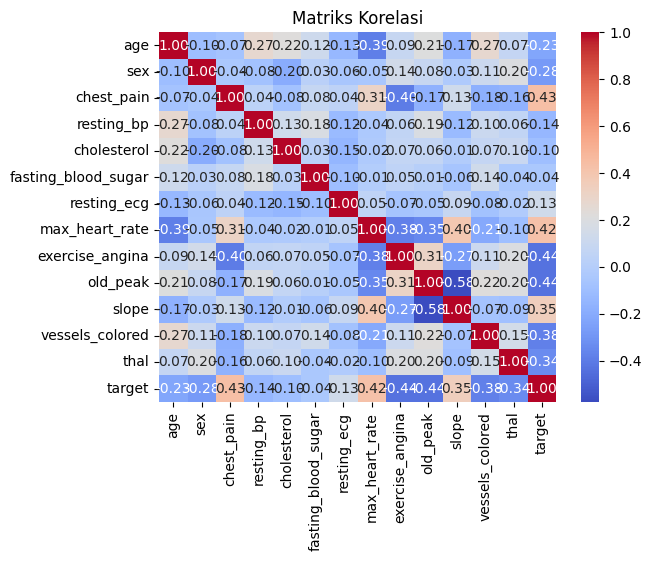

In [ ]:
# Menampilkan matriks korelasi
correlation_matrix = data.select([col(c).cast("float") for c in data.columns]).toPandas().corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriks Korelasi")
plt.show()

In [ ]:
# a. Membuat assembler dan split data
assembler = VectorAssembler(inputCols=data.columns[:-1], outputCol="features")
data_assembled = assembler.transform(data)
(train_data, test_data) = data_assembled.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# a. Membuat list model
models = [
    LogisticRegression(labelCol="target", featuresCol="features"),
    RandomForestClassifier(labelCol="target", featuresCol="features"),
    GBTClassifier(labelCol="target", featuresCol="features"),
    DecisionTreeClassifier(labelCol="target", featuresCol="features")
]

# Melatih dan mengevaluasi model
evaluator_acc = MulticlassClassificationEvaluator(labelCol="target", metricName="accuracy")

results = {}

for model in models:
    model_name = model.__class__.__name__
    print(f"\nTraining {model_name}")

    # Latih model
    model_fit = model.fit(train_data)

    # Membuat prediksi
    predictions = model_fit.transform(test_data)

    # Evaluasi model
    acc = evaluator_acc.evaluate(predictions)

    results[model_name] = {
        "Accuracy": acc,
    }

    print(f"{model_name} - Accuracy: {acc}")


Training LogisticRegression
LogisticRegression - Accuracy: 0.834319526627219

Training RandomForestClassifier
RandomForestClassifier - Accuracy: 0.8994082840236687

Training GBTClassifier
GBTClassifier - Accuracy: 1.0

Training DecisionTreeClassifier
DecisionTreeClassifier - Accuracy: 0.8816568047337278


In [ ]:
# b. Buat instance dari dua model terbaik
gbt = GBTClassifier(labelCol="target", featuresCol="features")
rf = RandomForestClassifier(labelCol="target", featuresCol="features")


# Penyetelan hyperparameter untuk GBTClassifier
gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_paramGrid, evaluator=evaluator_acc, numFolds=3)

gbt_cvModel = gbt_cv.fit(train_data)

gbt_bestModel = gbt_cvModel.bestModel

gbt_best_predictions = gbt_bestModel.transform(test_data)
gbt_best_acc = evaluator_acc.evaluate(gbt_best_predictions)
print("GBTClassifier - Best Accuracy (after tuning):", gbt_best_acc)

# Penyetelan hyperparameter untuk RandomForestClassifier
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, evaluator=evaluator_acc, numFolds=3)

rf_cvModel = rf_cv.fit(train_data)

rf_bestModel = rf_cvModel.bestModel

rf_best_predictions = rf_bestModel.transform(test_data)
rf_best_acc = evaluator_acc.evaluate(rf_best_predictions)
print("RandomForestClassifier - Best Accuracy (after tuning):", rf_best_acc)


GBTClassifier - Best Accuracy (after tuning): 1.0
RandomForestClassifier - Best Accuracy (after tuning): 1.0


+---+---+----------+----------+-----------+-------------------+-----------+--------------+---------------+--------+-----+---------------+----+------+--------------------+--------------------+--------------------+----------+
|age|sex|chest_pain|resting_bp|cholesterol|fasting_blood_sugar|resting_ecg|max_heart_rate|exercise_angina|old_peak|slope|vessels_colored|thal|target|            features|       rawPrediction|         probability|prediction|
+---+---+----------+----------+-----------+-------------------+-----------+--------------+---------------+--------+-----+---------------+----+------+--------------------+--------------------+--------------------+----------+
| 29|1.0|         1|       130|        204|                  0|          0|           202|              0|     0.0|    2|              0|   2|   1.0|[29.0,1.0,1.0,130...|[-1.6145888471147...|[0.03808235841283...|       1.0|
| 34|0.0|         1|       118|        210|                  0|          1|           192|              

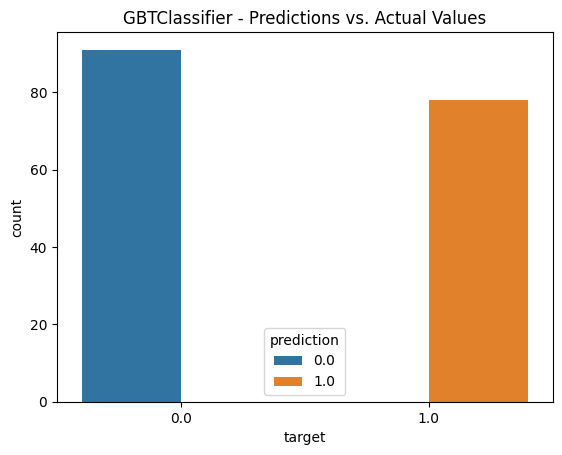

In [ ]:
# Prediksi menggunakan model GBTClassifier terbaik
gbt_best_predictions.show()

# Visualisasi Prediksi vs Nilai Sebenarnya
predictions_vs_actual = gbt_best_predictions.select("target", "prediction")
predictions_vs_actual_pd = predictions_vs_actual.toPandas()

sns.countplot(x="target", hue="prediction", data=predictions_vs_actual_pd)
plt.title("GBTClassifier - Predictions vs. Actual Values")
plt.show()

Karakteristik GBTClassifier Terbaik:
Max Depth: 5
Max Iterations: 20

Feature Importance:
age: 0.16048632922848222
chest_pain: 0.15626398311318537
old_peak: 0.12519509019096822
max_heart_rate: 0.11268253301139679
vessels_colored: 0.09420512663868844
cholesterol: 0.09304118997335756
thal: 0.08979703394778527
resting_bp: 0.08144974234541795
sex: 0.0302539019569072
slope: 0.01949400468671442
exercise_angina: 0.016978433013803224
resting_ecg: 0.013700185814967548
fasting_blood_sugar: 0.0064524460783259106
+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[29.0,1.0,1.0,130...|   1.0|       1.0|
|[34.0,0.0,1.0,118...|   1.0|       1.0|
|[34.0,1.0,3.0,118...|   1.0|       1.0|
|[35.0,0.0,0.0,138...|   1.0|       1.0|
|[35.0,1.0,0.0,126...|   0.0|       0.0|
|[35.0,1.0,1.0,122...|   1.0|       1.0|
|[37.0,1.0,2.0,130...|   1.0|       1.0|
|[38.0,1.0,2.0,138...|   1.0|       1.0|
|[39.0,0.0,2.0,94....|   1.0|       1.0|
|

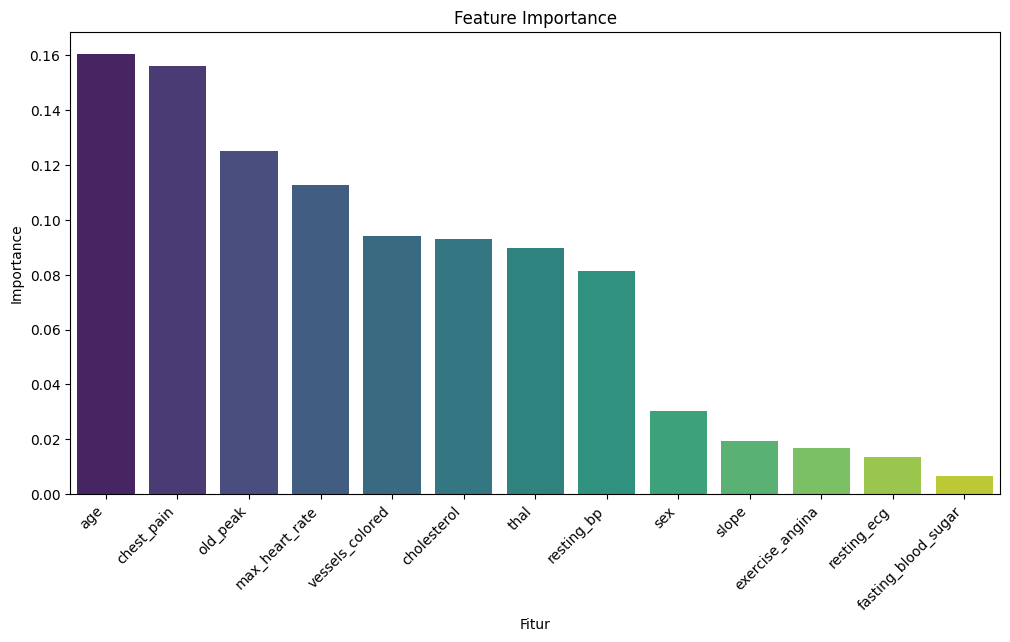

In [ ]:
# Karakteristik Model Terbaik (GBTClassifier)
print("Karakteristik GBTClassifier Terbaik:")
print(f"Max Depth: {gbt_bestModel.getMaxDepth()}")
print(f"Max Iterations: {gbt_bestModel.getMaxIter()}")

# Analisis Korelasi dengan Data
feature_importances = gbt_bestModel.featureImportances.toArray()
feature_names = data.columns[:-1]

feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\nFeature Importance:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

# Menampilkan Hasil Prediksi
predictions_df = gbt_best_predictions.select("features", "target", "prediction")
predictions_df.show(10)


# Grafik Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x=[f[0] for f in sorted_feature_importance], y=[f[1] for f in sorted_feature_importance], palette="viridis")
plt.title("Feature Importance")
plt.xlabel("Fitur")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha="right")
plt.show()


In [ ]:
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType

# Define the schema with correct data types
correct_schema = StructType([
    StructField("age", FloatType(), True),
    StructField("sex", FloatType(), True),
    StructField("chest_pain", FloatType(), True),
    StructField("resting_bp", FloatType(), True),
    StructField("cholesterol", FloatType(), True),
    StructField("fasting_blood_sugar", FloatType(), True),
    StructField("resting_ecg", FloatType(), True),
    StructField("max_heart_rate", FloatType(), True),
    StructField("exercise_angina", FloatType(), True),
    StructField("old_peak", FloatType(), True),
    StructField("slope", FloatType(), True),
    StructField("vessels_colored", FloatType(), True),
    StructField("thal", FloatType(), True),
    StructField("target", FloatType(), True)
])

# Input untuk Prediksi (termasuk kolom target)
input_data = input_data = [29.0,1.0,1.0,130.0,204.0,0.0,0.0,202.0,0.0,0.0,2.0,0.0,2.0,0.0]

# Transformasi input data menggunakan assembler
input_features = assembler.transform(spark.createDataFrame([input_data], schema=correct_schema)).select("features")

# Prediksi dengan Model Terbaik
prediction_result = gbt_bestModel.transform(input_features).select("prediction").collect()[0][0]

# Menampilkan Hasil Prediksi
print("\nHasil Prediksi untuk Input Data:")
print(f"Prediction: {prediction_result}")


Hasil Prediksi untuk Input Data:
Prediction: 1.0


In [ ]:
# Prediksi menggunakan model GBTClassifier terbaik
gbt_best_predictions.select("sex", "features", "target", "prediction").show(truncate=False)

+---+------------------------------------------------------------+------+----------+
|sex|features                                                    |target|prediction|
+---+------------------------------------------------------------+------+----------+
|1.0|[29.0,1.0,1.0,130.0,204.0,0.0,0.0,202.0,0.0,0.0,2.0,0.0,2.0]|1.0   |1.0       |
|0.0|[34.0,0.0,1.0,118.0,210.0,0.0,1.0,192.0,0.0,0.7,2.0,0.0,2.0]|1.0   |1.0       |
|1.0|[34.0,1.0,3.0,118.0,182.0,0.0,0.0,174.0,0.0,0.0,2.0,0.0,2.0]|1.0   |1.0       |
|0.0|[35.0,0.0,0.0,138.0,183.0,0.0,1.0,182.0,0.0,1.4,2.0,0.0,2.0]|1.0   |1.0       |
|1.0|[35.0,1.0,0.0,126.0,282.0,0.0,0.0,156.0,1.0,0.0,2.0,0.0,3.0]|0.0   |0.0       |
|1.0|[35.0,1.0,1.0,122.0,192.0,0.0,1.0,174.0,0.0,0.0,2.0,0.0,2.0]|1.0   |1.0       |
|1.0|[37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0]|1.0   |1.0       |
|1.0|[38.0,1.0,2.0,138.0,175.0,0.0,1.0,173.0,0.0,0.0,2.0,4.0,2.0]|1.0   |1.0       |
|0.0|[39.0,0.0,2.0,94.0,199.0,0.0,1.0,179.0,0.0,0.0,2.0,0.0,2.0] 